In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import KFold

## 1 - Prepare data

In [2]:
# Get data
df = pd.read_csv('/home/templar/Desktop/projects/zaz/client-projects/ai-bobby-classification/data/raw/gelation_hardness_oct_2024.csv')

# Get only rows with gel formation
df = df[df['If a gel can be formed (0-1)'] == 1]


# Define categorical columns
categorical_columns = ['Protein codes', 'Type of salt', 'Additives', 'Treatment code']

# Define numeric columns
numerical_columns = [
    'Samples stored (°C)',
    'ionic strength (M)',
    'Additives Concentration (%)',
    'Protein Concentration (%)',
    'pH',
    'Heating temperature (°C) for gel preparation',
    'Heating/hold time (min)',
    'Hardness/firmness/strength (g)'
]

# Convert object columns to categorical
for col in categorical_columns:
    df[col] = df[col].astype('category')

# Convert columns to numeric
for col in numerical_columns:
    df[col] = df[col].astype('float64')
# Columns to drop
columns_to_drop = [
    'Citation',
    'Citation Link',
    'Protein',
    'Treatment condition code',
    'Treatment condition value',
    'Treatment temperature ( °C)',
    'Treatment time (min)',
    'Storage time (h)',
    'If a gel can be formed (0-1)',
]

# Drop columns
df_clean = df.drop(columns=columns_to_drop, axis=1)

# Drop rows with missing target values
df_clean = df_clean.dropna(subset=['Hardness/firmness/strength (g)'])

In [3]:
def train_and_evaluate_model(X, y, k=5, model=Pipeline(steps=[]), 
                            metrics_list=[mean_absolute_error, mean_squared_error], 
                            numerical_cols=None, categorical_cols=None):
  """
  Trains and evaluates a regression model using K-fold cross-validation.

  Args:
    X: The feature matrix.
    y: The target variable.
    k: The number of folds for cross-validation.
    model: The regression model to use (must be a Pipeline if preprocessing is needed).
    metrics_list: A list of metric functions to evaluate the model.
    numerical_cols: List of numerical column names (needed for preprocessing).
    categorical_cols: List of categorical column names (needed for preprocessing).

  Returns:
    A dictionary of evaluation results for each fold and the average across all folds.
  """

  kf = KFold(n_splits=k, shuffle=True, random_state=42)
  results = []

  for fold, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_train_df = pd.DataFrame(X_train, columns=numerical_cols.tolist() + categorical_cols.tolist())
    X_test_df = pd.DataFrame(X_test, columns=numerical_cols.tolist() + categorical_cols.tolist())
    model.fit(X_train_df, y_train)  # Fit with DataFrame
    y_pred = model.predict(X_test_df)  # Predict with DataFrame

    fold_results = {}
    for metric in metrics_list:
      metric_name = metric.__name__
      fold_results[metric_name] = metric(y_test, y_pred)
    results.append(fold_results)

  # Calculate average results across all folds
  avg_results = {}
  for metric_name in results[0].keys():
    avg_results[metric_name] = np.mean([fold[metric_name] for fold in results])

  return avg_results

In [4]:
X = df_clean.drop('Hardness/firmness/strength (g)', axis=1)
y = df_clean['Hardness/firmness/strength (g)']

numerical_cols = X.select_dtypes(include=np.number).columns
categorical_cols = X.select_dtypes(include=['category']).columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = SimpleImputer(strategy='most_frequent')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols),
    ])

## 2 - Train models

In [5]:
RANDOM_STATE = 42

models = {
    "Decision Tree": Pipeline(steps=[('preprocessor', preprocessor), ('regressor', DecisionTreeRegressor(random_state=RANDOM_STATE))]),
    "Random Forest": Pipeline(steps=[('preprocessor', preprocessor), ('regressor', RandomForestRegressor(random_state=RANDOM_STATE))]),
    "LightGBM_no_preprocessing": Pipeline(steps=[('regressor', lgb.LGBMRegressor(random_state=RANDOM_STATE, verbose=-1, verbose_eval=False))]),
    "CatBoost_no_preprocessing": Pipeline(steps=[('regressor', CatBoostRegressor(random_state=RANDOM_STATE, verbose=False))]),
    "LightGBM": Pipeline(steps=[('preprocessor', preprocessor), ('regressor', lgb.LGBMRegressor(random_state=RANDOM_STATE, verbose=-1, verbose_eval=False))]),
    "CatBoost": Pipeline(steps=[('preprocessor', preprocessor), ('regressor', CatBoostRegressor(random_state=RANDOM_STATE, verbose=False))])
}

all_results = {}

for model_name, model in tqdm(models.items()):
    print(f"Training {model_name}...")
    avg_results = train_and_evaluate_model(
        X.values, y.values, model=model, 
        numerical_cols=numerical_cols, 
        categorical_cols=categorical_cols,
        metrics_list=[r2_score, mean_absolute_error, root_mean_squared_error, mean_squared_error, mean_absolute_percentage_error]
    )
    all_results[model_name] = avg_results


  0%|          | 0/6 [00:00<?, ?it/s]

Training Decision Tree...
Training Random Forest...


 33%|███▎      | 2/6 [00:00<00:01,  3.41it/s]

Training LightGBM_no_preprocessing...


 50%|█████     | 3/6 [00:00<00:01,  2.99it/s]

Training CatBoost_no_preprocessing...


 67%|██████▋   | 4/6 [00:02<00:01,  1.54it/s]

Training LightGBM...


 83%|████████▎ | 5/6 [00:02<00:00,  1.76it/s]

Training CatBoost...


100%|██████████| 6/6 [00:03<00:00,  1.62it/s]


In [6]:
# Print the results
# for model_name, results in all_results.items():
#     print(f"\n{model_name} Results:")
#     for metric_name, value in results.items():
#         print(f"  {metric_name}: {value:.4f}")

# You can further process the all_results dictionary, 
# e.g., convert it to a pandas DataFrame for easier analysis and comparison.
results_df = pd.DataFrame(all_results).T
print("\nSummary of Results:")
results_df.sort_values(by='mean_absolute_error', ascending=True).head(20)


Summary of Results:


,r2_score,mean_absolute_error,root_mean_squared_error,mean_squared_error,mean_absolute_percentage_error
Random Forest,0.896335,567.223224,1754.128104,3.112273e+06,9.327034e+16
CatBoost_no_preprocessing,0.947822,573.330385,1709.354710,3.182509e+06,2.966893e+16
CatBoost,0.946458,577.609852,1748.825035,3.310581e+06,3.599267e+16
Decision Tree,0.822683,585.898292,2062.724633,4.378084e+06,1.743167e+17
LightGBM_no_preprocessing,0.676355,2223.204771,7072.748414,6.864812e+07,8.124610e+16
LightGBM,0.675930,2231.568154,7077.469545,6.873874e+07,8.138867e+16


## 3 - Get feature importance for CatBoost Model (best model)

In [13]:
from sklearn.model_selection import train_test_split
catboost_model = CatBoostRegressor(random_state=RANDOM_STATE, verbose=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
catboost_model.fit(X_train, y_train, cat_features=list(categorical_cols))

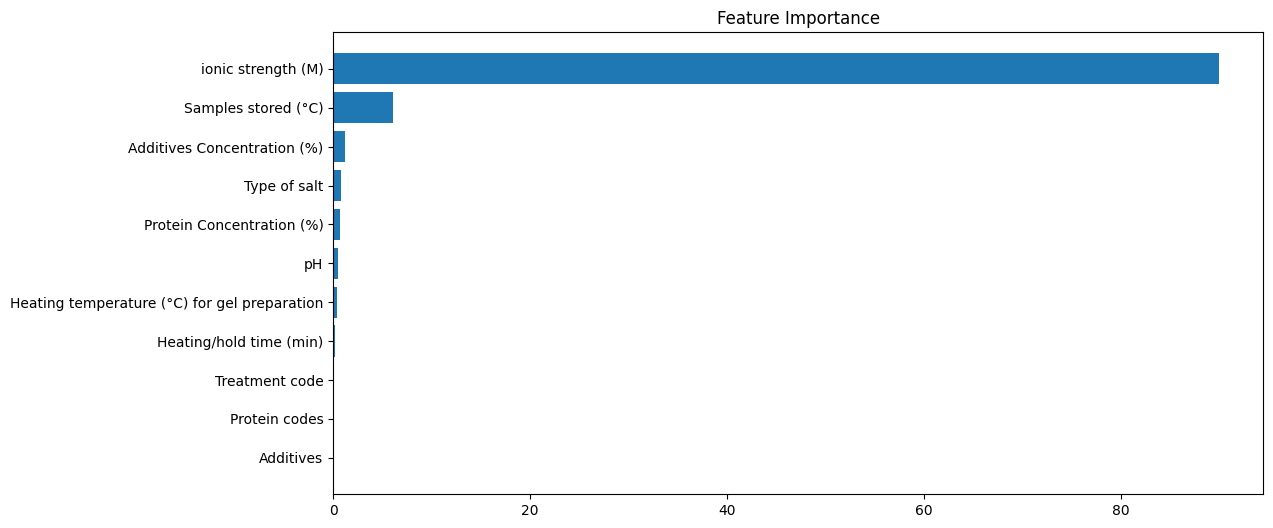

In [15]:
from matplotlib import pyplot as plt

feature_importance = catboost_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

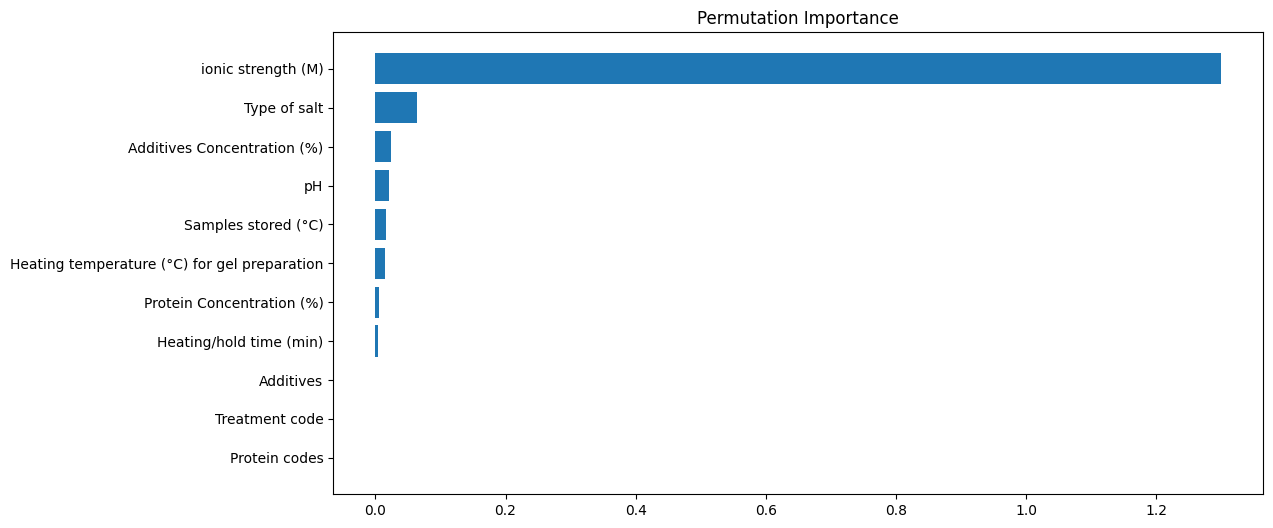

In [16]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(catboost_model, X_test, y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Permutation Importance')
plt.show()

### Explanation using SHAP values

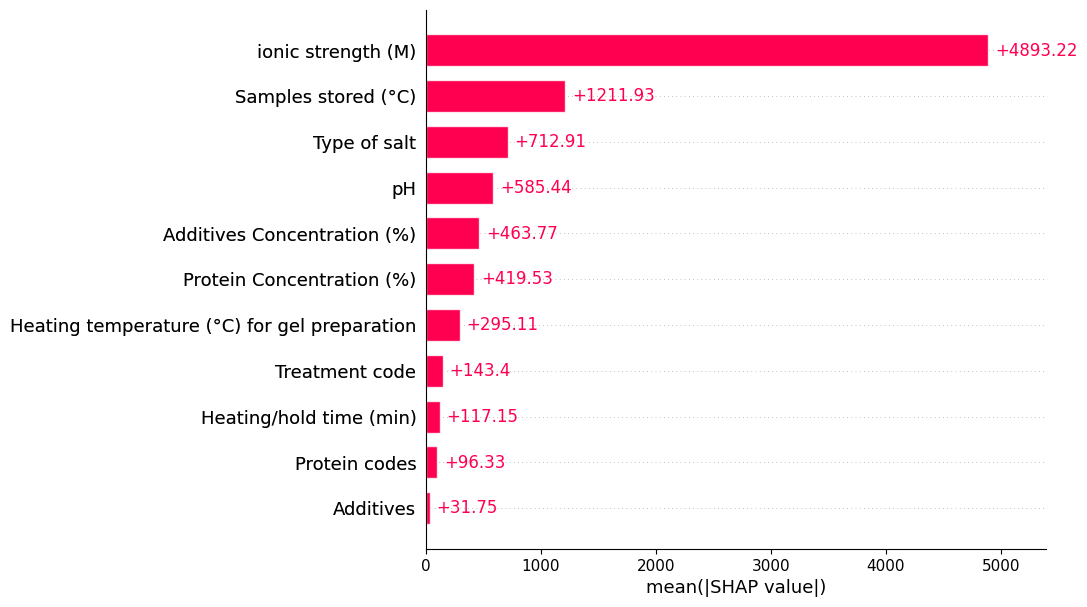

In [19]:
import shap
explainer = shap.TreeExplainer(catboost_model)
shap_values = explainer(X_test)
shap.plots.bar(shap_values, max_display=X_test.shape[0])

### Explanation for Technical Audience (Data Scientists):
This SHAP summary plot shows the average magnitude of SHAP values for features used in a **CatBoostRegressor model**. The SHAP value for each feature represents its contribution to the model's predictions. The features are ranked in descending order of importance based on their mean absolute SHAP values. 

- **"Ionic strength (M)"** has the highest importance, indicating it significantly impacts the model's predictions.
- Features like **"Samples stored (°C)"** and **"Type of salt"** also play crucial roles but are less influential compared to "Ionic strength."
- Features such as **"Additives"** and **"Protein codes"** have much smaller SHAP values, implying they contribute less to the prediction.

The results can guide feature engineering and domain understanding by highlighting which variables are driving the predictions.

---

### Explanation for Non-Technical Stakeholders:
This plot helps us understand which factors are most important for the predictions made by the model. Each bar represents how much a specific factor (like **"Ionic strength"** or **"Samples stored temperature"**) influences the model's outcomes on average.

- The top factor, **"Ionic strength"**, has the biggest influence, meaning it strongly affects how the predictions change.
- Factors like the **"storage temperature"** and the **"type of salt"** are also quite important, but less so than ionic strength.
- Factors lower down, like **"Additives"**, have very little impact on the model's predictions.

This information can help focus on the most critical factors for decision-making or further experimentation.

In [28]:
shap.initjs()
shap.plots.force(shap_values[0, ...])

In [30]:
shap.initjs()
shap.plots.force(shap_values[11, ...])

The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

### Using DiCE library for counterfactual explanations

In [40]:
import dice_ml
from dice_ml import Dice

d_gel = dice_ml.Data(dataframe=df_clean,
                      continuous_features=list(numerical_cols),
                      outcome_name='Hardness/firmness/strength (g)')

# We provide the type of model as a parameter (model_type)
catboost_with_preprocessing = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', CatBoostRegressor(random_state=RANDOM_STATE, verbose=False))])
catboost_with_preprocessing.fit(X_train, y_train)
m_gel = dice_ml.Model(model=catboost_with_preprocessing, backend="sklearn", model_type='regressor')
exp_genetic_gel = Dice(d_gel, m_gel, method="genetic")

In [45]:
# Multiple queries can be given as input at once
# query_instances_gel = X_test[20:22]
# genetic_gel = exp_genetic_gel.generate_counterfactuals(
#     query_instances_gel,
#     total_CFs=2,
#     desired_range=[100, 500])
# genetic_gel.visualize_as_dataframe(show_only_changes=True)